In [26]:
import scrapy
import json
import requests
import requests_cache
import numpy as np
import pandas as pd
import seaborn as sns
import urlparse
import csv
import urllib
import os
import os.path
from bs4 import BeautifulSoup
import sys
from lxml import html
import lxml.html as lx
from datetime import time, datetime
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from IPython.display import HTML

import matplotlib.pyplot as plt
requests_cache.install_cache('demo_cache')

In [27]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>''')
def Popular_Movies_search(year,pages,num):
    count = 0
    names = []
    
    for i in range(1,(pages+1)):
        url = "http://www.imdb.com/search/title?title_type=feature&year=" + str(year) + "," +str(year) + "&" "page=" + str(i) + "&sort=moviemeter,asc&" +  "&" + "ref_=adv_prv"        
        r = requests.get(url)
        soup = BeautifulSoup(r.content, "html.parser")
        search_results = soup.find_all("p", class_="sort-num_votes-visible")
        vote = int(search_results[0].find_all('span')[1].text.replace(',',''))
        soup = BeautifulSoup(r.content, "html.parser")
        search_results = soup.find_all("div", class_="lister-item-content")
        

        for result in search_results:
            try:
                vote = int(result.find_all('p')[3].find_all('span')[1].text.replace(',',''))
                if vote < 10000:
                    continue
            except:
                continue
            header = result.find("h3", class_="lister-item-header")
            title = header.a
            b = title.get_text().encode('utf-8')
            names.append(b)
            count = count + 1
            if count == num:
                return names
    
    return names

In [41]:
def Movie_info_search(movie):
    url = 'http://www.omdbapi.com/?t='+movie.replace(' ','+')+'&plot=full&tomatoes=true'
    response = requests.get(url)
    try:
        js = response.json()
        map(js.pop, ['Plot','DVD','tomatoFresh','Type','Response','tomatoImage','tomatoConsensus','tomatoMeter','tomatoRating','tomatoRotten','tomatoURL','tomatoUserMeter','tomatoUserRating','tomatoUserReviews','tomatoReviews'])
        
        imdb = str(js['imdbID'])
        url1 = 'http://www.imdb.com/title/' + imdb + '/?ref_=fn_al_tt_1'
        r1 = requests.get(url1)
        soup1 = BeautifulSoup(r1.content,"html.parser")
        
        
        for itr in soup1.find_all('div',class_ = 'txt-block'):
            if 'Budget' in itr.text:
                js['Budget'] = itr.contents[2].replace(' ','').replace('\n','')
            if 'Gross' in itr.text:
                js['BoxOffice'] = itr.contents[2].replace(' ','').replace('\n','')
                break
        
        url2 = 'http://www.imdb.com/title/' + imdb + '/ratings?ref_=tt_ov_rt'
        r2 = requests.get(url2)
        soup2 = BeautifulSoup(r2.content, "html.parser")
        res_2 = soup2.find_all('td')
        rates = []

        for i in xrange(14):
            number = str(res_2[37 + 3*i].text.replace(u'\xa0',u''))
            rate = str(res_2[38 + 3*i].find_all('img')[0].text.replace(u'\xa0',u''))
            rates.append(number)
            rates.append(rate)
        params = {'<18 rating':float(rates[5]),
                  '18-29 rating':float(rates[11]),
                  '30-44 rating':float(rates[17]),
                  '45+ rating':float(rates[23])}
    except:
        return {}     
    js.update(params)
    

    return js

In [4]:
films_name = []
for year in xrange(0,27):
    films_name.append(Popular_Movies_search(year+1990,10,100))

In [ ]:
films_data = pd.DataFrame()
count  = 1990
for year in films_name:
    buff = []
    buff.append(pd.DataFrame.from_dict(Movie_info_search(i) for i in year))
    films_data = pd.concat([films_data,buff[0]])

In [7]:
Films_data = films_data
Films_data = Films_data[['Title','Year','Director','Actors','Writer','Country','Genre','Awards','Budget','BoxOffice','Language','Poster','Production','Rated','Released','Runtime','Website','imdbID','imdbRating','imdbVotes','Metascore','<18 rating','18-29 rating','30-44 rating','45+ rating']]         
Films_data = Films_data.dropna(axis = 0,how = 'any')
Films_data = Films_data.reset_index(drop = True)
Films_data['BoxOffice'] = pd.to_numeric(Films_data['BoxOffice'].map(lambda x: str(x).replace('$','').replace(',','')),errors ='coerce')
Films_data['Budget'] = pd.to_numeric(Films_data['Budget'].map(lambda x: str(x.encode('utf-8')).replace('\xc2\xa3','').replace('\xe2\x82\xac','').replace('$','').replace(',','')),errors ='coerce')
Films_data['Year'] = pd.to_numeric(Films_data['Year'], errors='coerce')
Films_data['Metascore'] = pd.to_numeric(Films_data['Metascore'], errors='coerce')
Films_data['imdbRating'] = pd.to_numeric(Films_data['imdbRating'], errors='coerce')

In [9]:
Wrong = []
for i in xrange(1,2363):
    if Films_data.iloc[i]['Year'] - Films_data.iloc[i-1]['Year'] != 0 and Films_data.iloc[i]['Year'] - Films_data.iloc[i+1]['Year'] != 0 :
        Wrong.append(i)

Films_data = Films_data.drop(Wrong)
Films_data = Films_data.dropna(subset=[['Genre']])
Films_data = Films_data.reset_index(drop = True)

In [21]:
Films_data = pd.read_csv("Films_data.csv",encoding = 'utf-8').drop('Unnamed: 0',1)

In [5]:
target = ['Action', 'Adventure', 'Comedy', 'Crime', 'Drama', 'Romance', 'Thriller']

In [6]:
Index = [[],[],[],[],[],[],[]]
for i in xrange(2304):
    for j in range(7):
        if target[j] in Films_data.iloc[[i]]['Genre'][i]:
            Index[j].append(i)

In [7]:
Action_Film = Films_data.iloc[Index[0]]
Adventure_Film = Films_data.iloc[Index[1]]
Comedy_Film = Films_data.iloc[Index[2]]
Crime_Film = Films_data.iloc[Index[3]]
Drama_Film = Films_data.iloc[Index[4]]
Romance_Film = Films_data.iloc[Index[5]]
Thriller_Film = Films_data.iloc[Index[6]]

In [8]:
targetwords = []
url1 = 'https://en.wikipedia.org/wiki/List_of_films_based_on_DC_Comics'
r = requests.get(url1)
soup = BeautifulSoup(r.content, "html.parser")
targetwords = []
for i in range(5,31):
    tmp = soup.find_all('table')[0].find_all('tr')[i].find('a')
    targetwords.append(tmp.attrs['title'].split(' (')[0])

In [9]:
url2 = 'https://en.wikipedia.org/wiki/List_of_films_based_on_Marvel_Comics'
r = requests.get(url2)
soup = BeautifulSoup(r.content, "html.parser")
for i in range(4,47):
    tmp = soup.find_all('table')[0].find_all('tr')[i].find('a')
    targetwords.append(tmp.attrs['title'].split(' (')[0])

In [10]:
ser_index = []
for i in range(668):
    for j in targetwords:
        test = Action_Film.iloc[[i]]['Title'][Action_Film.iloc[[i]]['Title'].index[0]]
        if j in test:
            ser_index.append(i)
            break
Act_Series_movie = Action_Film.iloc[ser_index]      

In [11]:
ser_index = []
for i in range(536):
    test = Adventure_Film.iloc[[i]]['Title'][Adventure_Film.iloc[[i]]['Title'].index[0]]
    for j in targetwords:
        if j in test:
            ser_index.append(i)
            break
Adv_Series_movie = Adventure_Film.iloc[ser_index]

In [12]:
Act_Count_rate = []
Adv_Count_rate = []
Com_Count_rate = []
Dra_Count_rate = []

Act_Box_rate = []
Adv_Box_rate = []
Com_Box_rate = []
Dra_Box_rate = []

Act_Bugt = []
Adv_Bugt = []
Com_Bugt = []
Dra_Bugt = []

IMDB = [[],[],[],[],[]]
Meta = [[],[],[],[],[]]

Rating = [[],[],[],[],[],[]]

Seri_box = [[],[],[],[]]

for i in range(27):
    test = 'Year == '+ str(1990 + i)
    a1 = Action_Film.query(test)["BoxOffice"].sum()
    a2 = Adventure_Film.query(test)["BoxOffice"].sum()
    a3 = Comedy_Film.query(test)["BoxOffice"].sum()
    a4 = Drama_Film.query(test)["BoxOffice"].sum()
    a5 = float(Action_Film.query(test).shape[0])/100
    a6 = float(Adventure_Film.query(test).shape[0])/100
    a7 = float(Comedy_Film.query(test).shape[0])/100
    a8 = float(Drama_Film.query(test).shape[0])/100
    
    a9 = Action_Film.query(test)['Budget'].mean()
    a10 = Adventure_Film.query(test)['Budget'].mean()
    a11 = Comedy_Film.query(test)['Budget'].mean()
    a12 = Drama_Film.query(test)['Budget'].mean()
    
    a13 = Action_Film.query(test)['imdbRating'].mean()
    a14 = Adventure_Film.query(test)['imdbRating'].mean()
    a15 = Comedy_Film.query(test)['imdbRating'].mean()
    a16 = Drama_Film.query(test)['imdbRating'].mean()
    
    a17 = Action_Film.query(test)['Metascore'].mean()
    a18 = Adventure_Film.query(test)['Metascore'].mean()
    a19 = Comedy_Film.query(test)['Metascore'].mean()
    a20 = Drama_Film.query(test)['Metascore'].mean()
    
    a21 = Films_data.query(test)['imdbRating'].mean()
    a22 = Films_data.query(test)['Metascore'].mean()
    
    a23 = Act_Series_movie.query(test)['BoxOffice'].mean()
    a24 = Adv_Series_movie.query(test)['BoxOffice'].mean()
    
    a25 = Action_Film.query(test)["BoxOffice"].sum()
    a26 = Adventure_Film.query(test)["BoxOffice"].sum()
    
    a27 = Action_Film.query(test)['<18 rating'].mean()
    a28 = Action_Film.query(test)['18-29 rating'].mean()
    a29 = Action_Film.query(test)['30-44 rating'].mean()
    a30 = Action_Film.query(test)['45+ rating'].mean()

    a31 = Comedy_Film.query(test)['<18 rating'].mean()
    a32 = Comedy_Film.query(test)['18-29 rating'].mean()
    a33 = Comedy_Film.query(test)['30-44 rating'].mean()
    a34 = Comedy_Film.query(test)['45+ rating'].mean()
    
    
    b = Films_data.query(test)["BoxOffice"].sum()
    c = Films_data.query(test)['Budget'].mean()
    
    Act_Box_rate.append(a1/b)
    Adv_Box_rate.append(a2/b)
    Com_Box_rate.append(a3/b)
    Dra_Box_rate.append(a4/b)
    
    Act_Count_rate.append(a5)
    Adv_Count_rate.append(a6)
    Com_Count_rate.append(a7)
    Dra_Count_rate.append(a8)
    
    Act_Bugt.append(a9/c)
    Adv_Bugt.append(a10/c)
    Com_Bugt.append(a11/c)
    Dra_Bugt.append(a12/c)
    
    IMDB[0].append(a13)
    IMDB[1].append(a14)
    IMDB[2].append(a15)
    IMDB[3].append(a16)
    IMDB[4].append(a21)
                                 
    Meta[0].append(a17)
    Meta[1].append(a18)
    Meta[2].append(a19)
    Meta[3].append(a20)
    Meta[4].append(a22)
    
    Seri_box[0].append(a23/a25)
    Seri_box[1].append(a24/a26)
    Seri_box[2].append(a9/a25)
    Seri_box[3].append(a10/a26)
    
    Rating[0].append(a27)
    Rating[1].append(a28)
    Rating[2].append(a29)
    Rating[3].append(a30)
    Rating[4].append(np.var([a27,a28,a29,a30]))
    Rating[5].append(np.var([a31,a32,a33,a34]))
                                 
    
Year = range(1990,2017)
Rate = pd.DataFrame()
Rate['Year'] = Year
Rate['Act_Box_rate'] = Act_Box_rate
Rate['Adv_Box_rate'] = Adv_Box_rate
Rate['Com_Box_rate'] = Com_Box_rate
Rate['Dra_Box_rate'] = Dra_Box_rate
Rate['Act_Count_rate'] = Act_Count_rate
Rate['Adv_Count_rate'] = Adv_Count_rate
Rate['Com_Count_rate'] = Com_Count_rate
Rate['Dra_Count_rate'] = Dra_Count_rate
Rate['Act_Bugt'] = Act_Bugt
Rate['Adv_Bugt'] = Adv_Bugt
Rate['Com_Bugt'] = Com_Bugt
Rate['Dra_Bugt'] = Dra_Bugt
Rate['Act_IMDB'] = IMDB[0]
Rate['Adv_IMDB'] = IMDB[1]
Rate['Com_IMDB'] = IMDB[2]
Rate['Dra_IMDB'] = IMDB[3]
Rate['Average_IMDB'] = IMDB[4]
Rate['Act_Meta'] = Meta[0]
Rate['Adv_Meta'] = Meta[1]
Rate['Com_Meta'] = Meta[2]
Rate['Dra_Meta'] = Meta[3]
Rate['Average_Meta'] = Meta[4]
Rate['Act_Ser_contri'] = Seri_box[0]
Rate['Adv_Ser_contri'] = Seri_box[1]
Rate['Act_contri'] = Seri_box[2]
Rate['Adv_contri'] = Seri_box[3]
Rate['<18 rating'] = Rating[0]
Rate['18-29 rating'] = Rating[1]
Rate['30-44 rating'] = Rating[2]
Rate['45+ rating'] = Rating[3]
Rate['var1'] = Rating[4]
Rate['var2'] = Rating[5]

In [15]:
import re
genre = (',').join(list(Films_data['Genre']))
genrelist = list(set(re.split(', |,',genre)))

getdict = dict()
for g in range(27):
    y = 1990 + g
    getyear = Films_data.loc[Films_data['Year'] == y ]
    genrecount = [0] * 20

    for i in getyear['Genre']:
        for j in range(len(genrelist)): 
            if genrelist[j] in i:
                genrecount[j] = genrecount[j] + 1
    getdict[str(y)] = genrecount 
            


getdict
genredf = pd.DataFrame.from_dict(getdict, orient='columns', dtype=None).transpose()
genredf.columns = genrelist
genredf = genredf.transpose()

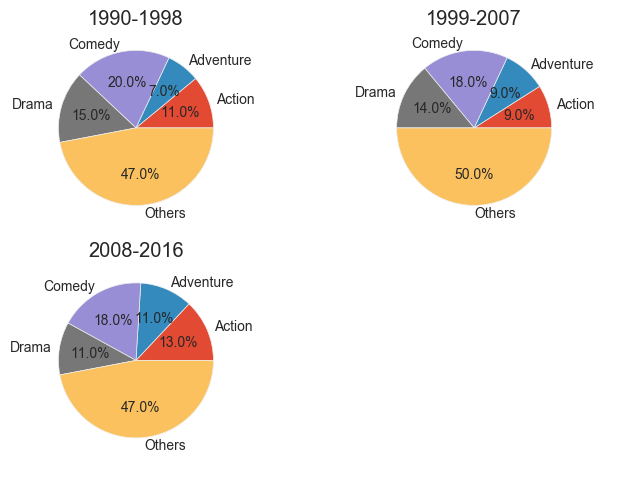

In [31]:
perioddf = pd.DataFrame(columns = np.array(['1990-1998','1999-2007','2008-2016']))
#perioddf.columns = np.array(['1990-1998','1999-2007','2008-2016'])
a = genredf['1990'] + genredf['1991'] + genredf['1992'] + genredf['1993'] + genredf['1994'] + genredf['1995'] + genredf['1996'] + genredf['1997'] +genredf['1998']
b = genredf['1999'] + genredf['2000'] + genredf['2001'] + genredf['2002'] + genredf['2003'] + genredf['2004'] + genredf['2005'] + genredf['2006'] +genredf['2007']
c = genredf['2008'] + genredf['2009'] + genredf['2010'] + genredf['2011'] + genredf['2012'] + genredf['2013'] + genredf['2014'] + genredf['2015'] +genredf['2016']
perioddf['1990-1998'] = a
perioddf['1999-2007'] = b
perioddf['2008-2016'] = c
perioddf


#genredf
fracdf = pd.DataFrame()
perioddict = dict()
for i in perioddf.columns.values:
    tmp = range(5)
    total = round(perioddf[i].sum(),2)
    tmp[0] = round(perioddf[i]['Action']/total,2)
    tmp[1] = round(perioddf[i]['Adventure']/total,2)
    tmp[2] = round(perioddf[i]['Drama']/total,2)
    tmp[3] = round(perioddf[i]['Comedy']/total,2)
    tmp[4] = round(1 - tmp[0] - tmp[1] - tmp[2] - tmp[3],2)
    perioddict[i] = tmp


pdf = pd.DataFrame.from_dict(perioddict, orient='columns', dtype=None).transpose()
#fracdf.columns = genrelist

pdflis t = ['Action','Adventure','Comedy','Drama','Others']
pdf.columns = pdflist
pdf = pdf.transpose()
pdf

df = pdf[['1990-1998','1999-2007','2008-2016']].multiply(100)


plt.style.use('ggplot')
colors = plt.rcParams['axes.color_cycle']

fig, axes = plt.subplots(nrows=2, ncols=2)
for ax in axes.flat:
    ax.axis('off')

for ax, col in zip(axes.flat, df.columns):
    ax.pie(df[col], labels=df.index, autopct='%1.1f%%', colors=colors)
    ax.set(ylabel='', title=col, aspect='equal')

#axes[0, 0].legend(bbox_to_anchor=(0, 0.5))

fig.savefig('your_file.png') # Or whichever format you'd like
plt.show()

In [18]:
import mpld3
from mpld3 import plugins, utils
import matplotlib
import matplotlib.pyplot as plt

class LinkedView(plugins.PluginBase):
    """A simple plugin showing how multiple axes can be linked"""

    JAVASCRIPT = """
    mpld3.register_plugin("linkedview", LinkedViewPlugin);
    LinkedViewPlugin.prototype = Object.create(mpld3.Plugin.prototype);
    LinkedViewPlugin.prototype.constructor = LinkedViewPlugin;
    LinkedViewPlugin.prototype.requiredProps = ["idpts", "idline", "data"];
    LinkedViewPlugin.prototype.defaultProps = {}
    function LinkedViewPlugin(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    LinkedViewPlugin.prototype.draw = function(){
      var pts = mpld3.get_element(this.props.idpts);
      var line = mpld3.get_element(this.props.idline);
      var data = this.props.data;

      function mouseover(d, i){
        line.data = data[i];
        line.elements().transition()
            .attr("d", line.datafunc(line.data))
            .style("stroke", this.style.fill);
      }
      pts.elements().on("mouseover", mouseover);
    };
    """

    def __init__(self, points, line, linedata):
        if isinstance(points, matplotlib.lines.Line2D):
            suffix = "pts"
        else:
            suffix = None

        self.dict_ = {"type": "linkedview",
                      "idpts": utils.get_id(points, suffix),
                      "idline": utils.get_id(line),
                      "data": linedata}

fig, ax = plt.subplots(2)

# scatter periods and amplitudes
np.random.seed(0)
P = np.array(range(27))
A = np.array([sum(getdict[str(1990+i)]) for i in range(27)])
x = np.array(range(1,21))
data = np.array([[x, np.array([getdict[str(1990+i)] for i in range(27)][Pi])]
                 for (Ai, Pi) in zip(A, P)])

area = np.pi *0.5*(A/20)**2 

points = ax[1].scatter(P, A, c=P, cmap='viridis_r',
                       s=area, alpha=0.5)
ax[1].set_xlabel('Year')
ax[1].set_ylabel('total count of Genre')

# create the line object
lines = ax[0].plot(x, 0 * x, '-w', lw=3, alpha=0.5)
ax[0].set_ylim(-1, 60)
ax[0].set_title("Hover over points to see each genre count in that year")
ax[0].set_xlabel('Genre')
ax[0].set_ylabel('count')


linedata = data.transpose(0, 2, 1).tolist()
plugins.connect(fig, LinkedView(points, lines[0], linedata))

mpld3.display()

In [30]:
import plotly.plotly as py
import plotly.graph_objs as go

#{'Action', 'Adventure', 'Comedy', 'Crime', 'Drama', 'Romance', 'Thriller'}

my_x = list(genredf.columns.values)
trace1 = go.Bar(
    x= my_x,
    y=fracdf['Action'],
    name= 'Action'
)
trace2 = go.Bar(
    x= my_x,
    y=fracdf['Adventure'],
    name= 'Adventure'
)
trace3 = go.Bar(
    x= my_x,
    y=fracdf['Comedy'],
    name='Comedy'
)
trace4 = go.Bar(
    x= my_x,
    y= fracdf['Drama'],
    name= 'Drama'
)
trace5 = go.Bar(
    x= my_x,
    y=fracdf['Others'],
    name= 'Others'
)


data = [trace5, trace4,trace3,trace2, trace1]
layout = go.Layout(
    barmode='stack'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='stacked-bar')

KeyError: 'Action'

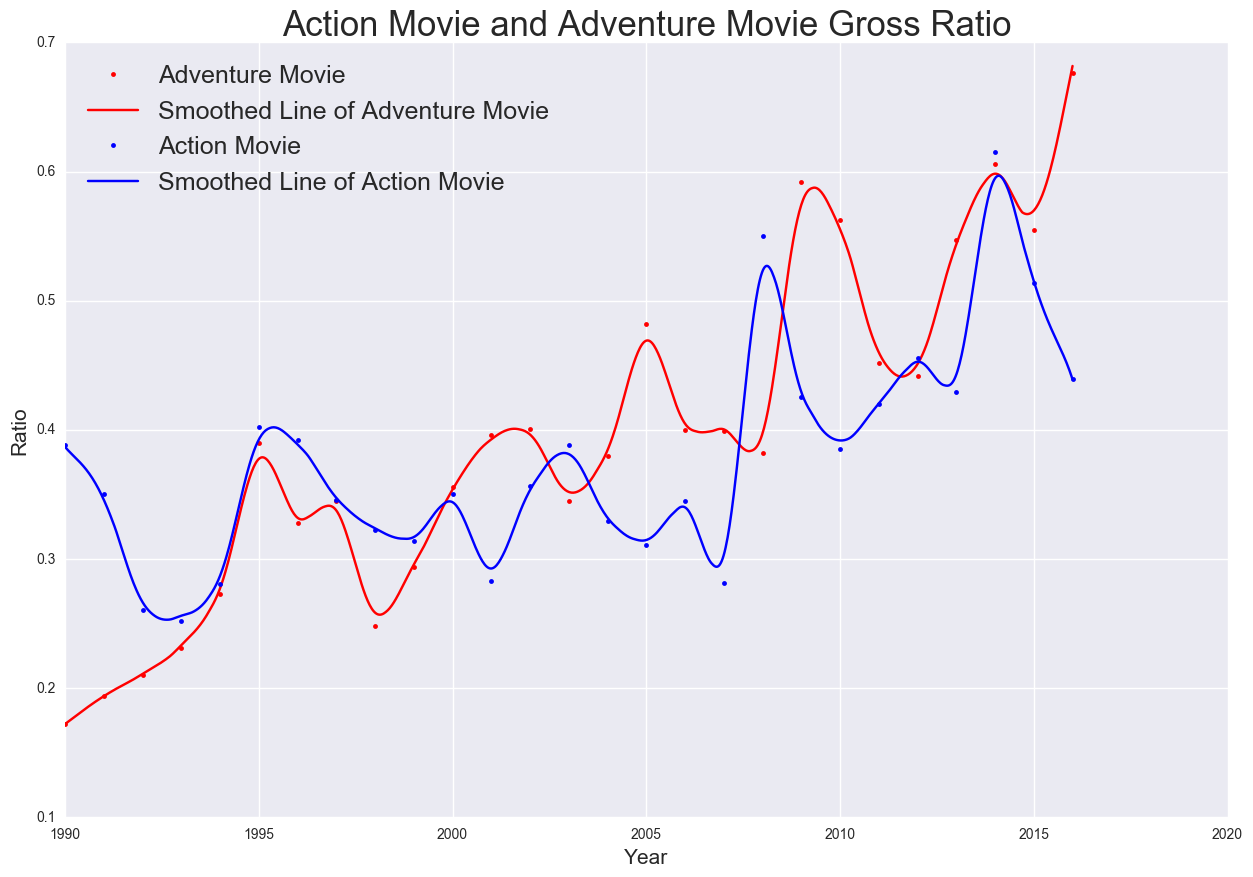

In [15]:
x = np.array(Rate['Year'])
y1 = np.array(Rate['Act_Box_rate'])
y2 = np.array(Rate['Adv_Box_rate'])

xx = np.linspace(x.min(),x.max(), 1000)

# interpolate + smooth
itp1 = interp1d(x,y1, kind='linear')
itp2 = interp1d(x,y2, kind='linear')
window_size, poly_order = 101, 4
yy1_sg = savgol_filter(itp1(xx), window_size, poly_order)
yy2_sg = savgol_filter(itp2(xx), window_size, poly_order)


fig, ax = plt.subplots(figsize=(15, 10))

ax.plot(x, y2, 'r.', label= 'Adventure Movie',color = 'red')
ax.plot(xx, yy2_sg, 'k', label= "Smoothed Line of Adventure Movie",color = 'red')

ax.plot(x, y1, 'r.', label= 'Action Movie',color = 'Blue')
ax.plot(xx, yy1_sg, 'k', label= "Smoothed Line of Action Movie",color = 'Blue')

plt.xlabel('Year',fontsize = 15)
plt.ylabel('Ratio',fontsize = 15)
plt.title('Action Movie and Adventure Movie Gross Ratio',fontsize = 25)
plt.legend(loc='best',prop={'size':18})
plt.show()

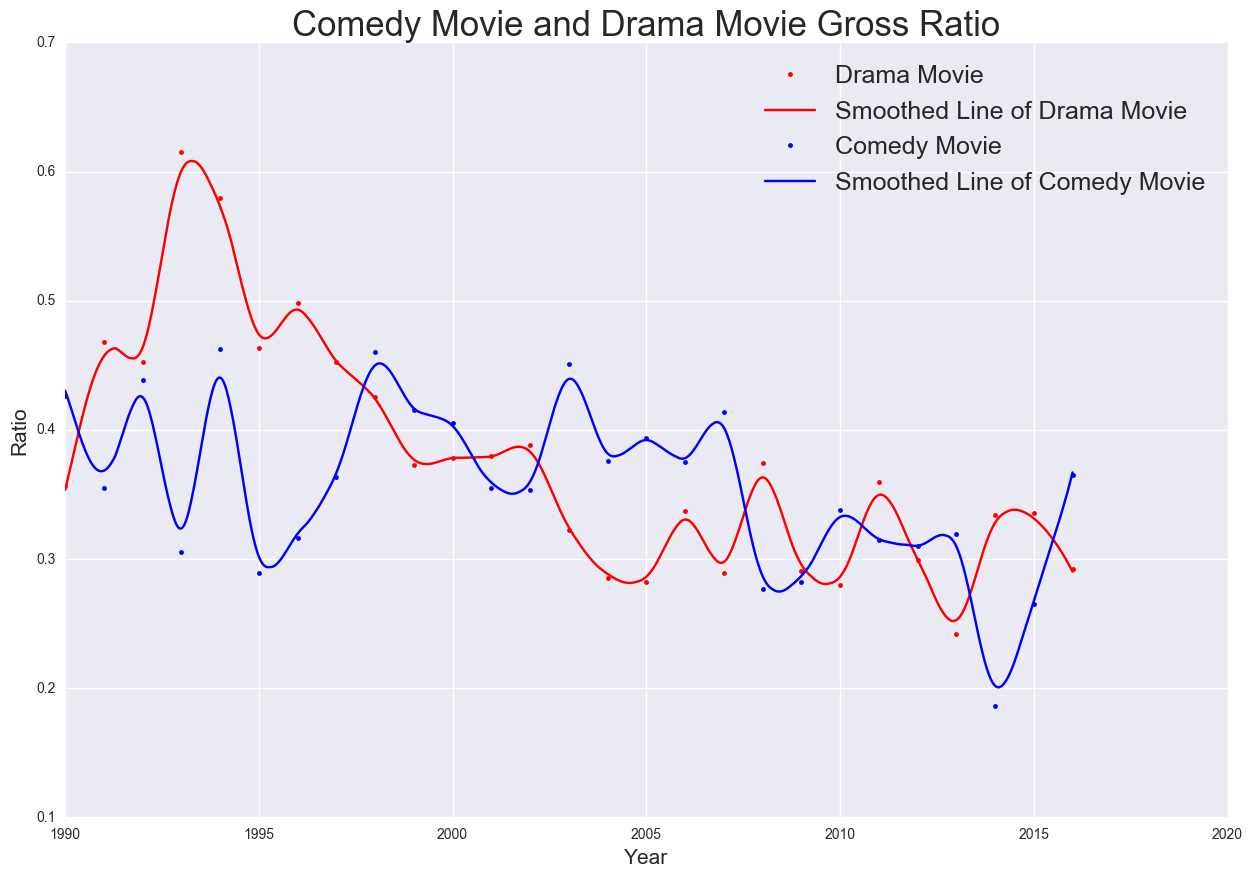

In [17]:
x = np.array(Rate['Year'])
y1 = np.array(Rate['Com_Box_rate'])
y2 = np.array(Rate['Dra_Box_rate'])

xx = np.linspace(x.min(),x.max(), 1000)

# interpolate + smooth
itp1 = interp1d(x,y1, kind='linear')
itp2 = interp1d(x,y2, kind='linear')
window_size, poly_order = 101, 4
yy1_sg = savgol_filter(itp1(xx), window_size, poly_order)
yy2_sg = savgol_filter(itp2(xx), window_size, poly_order)


fig, ax = plt.subplots(figsize=(15, 10))

ax.plot(x, y2, 'r.', label= 'Drama Movie',color = 'red')
ax.plot(xx, yy2_sg, 'k', label= "Smoothed Line of Drama Movie",color = 'red')

ax.plot(x, y1, 'r.', label= 'Comedy Movie',color = 'Blue')
ax.plot(xx, yy1_sg, 'k', label= "Smoothed Line of Comedy Movie",color = 'Blue')

plt.xlabel('Year',fontsize = 15)
plt.ylabel('Ratio',fontsize = 15)
plt.title('Comedy Movie and Drama Movie Gross Ratio',fontsize = 25)
plt.legend(loc='best',prop={'size':18})
plt.show()

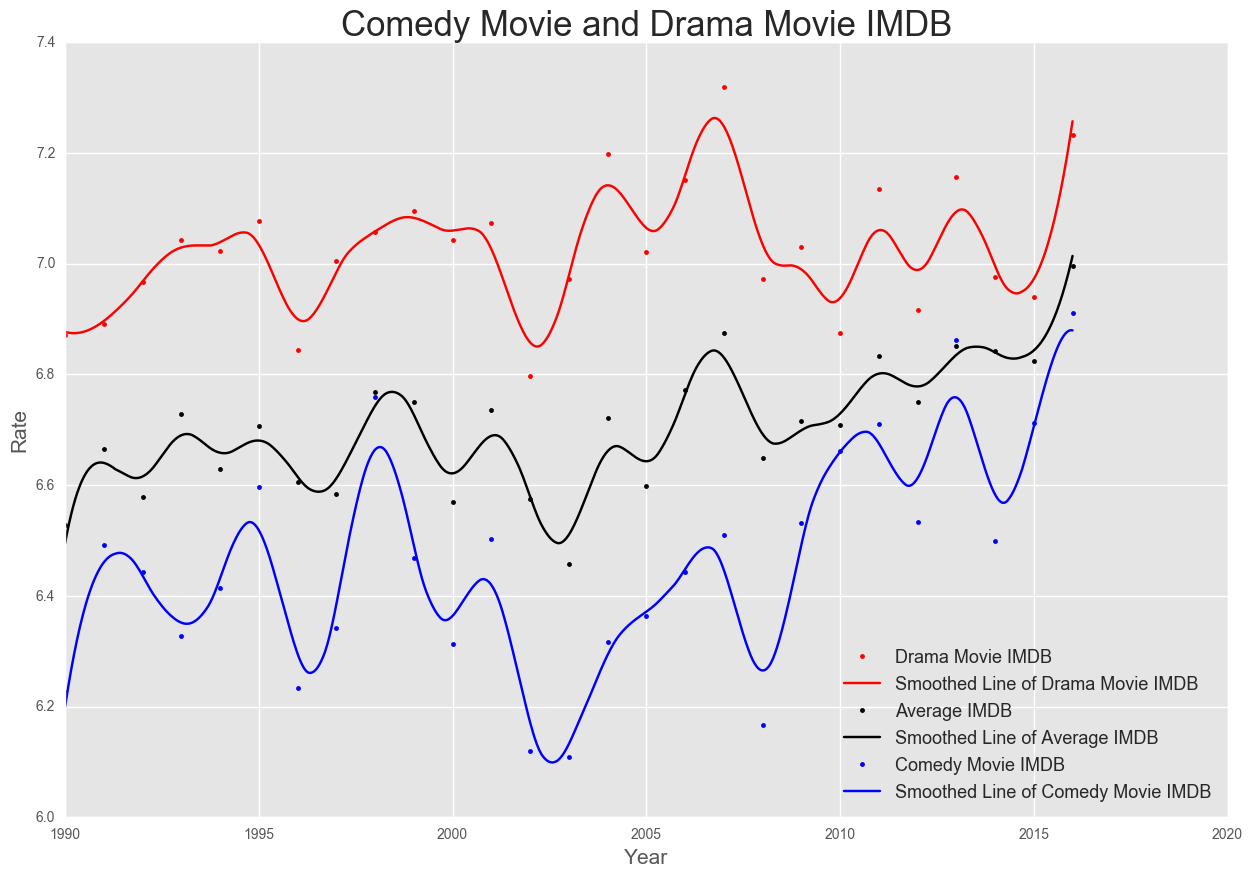

In [32]:
x = np.array(Rate['Year'])
y1 = np.array(Rate['Com_IMDB'])
y2 = np.array(Rate['Dra_IMDB'])
y3 = np.array(Rate['Average_IMDB'])

xx = np.linspace(x.min(),x.max(), 1000)

# interpolate + smooth
itp1 = interp1d(x,y1, kind='linear')
itp2 = interp1d(x,y2, kind='linear')
itp3 = interp1d(x,y3, kind='linear')
window_size, poly_order = 101, 3
yy1_sg = savgol_filter(itp1(xx), window_size, poly_order)
yy2_sg = savgol_filter(itp2(xx), window_size, poly_order)
yy3_sg = savgol_filter(itp3(xx), window_size, poly_order)



fig, ax = plt.subplots(figsize=(15, 10))

ax.plot(x, y2, 'r.', label= 'Drama Movie IMDB',color = 'red')
ax.plot(xx, yy2_sg, 'k', label= "Smoothed Line of Drama Movie IMDB",color = 'red')

ax.plot(x, y3, 'r.', label= 'Average IMDB',color = 'Black')
ax.plot(xx, yy3_sg, 'k', label= "Smoothed Line of Average IMDB",color = 'Black')

ax.plot(x, y1, 'r.', label= 'Comedy Movie IMDB',color = 'Blue')
ax.plot(xx, yy1_sg, 'k', label= "Smoothed Line of Comedy Movie IMDB",color = 'Blue')

plt.xlabel('Year',fontsize = 15)
plt.ylabel('Rate',fontsize = 15)
plt.title('Comedy Movie and Drama Movie IMDB',fontsize = 25)
plt.legend(loc='best',prop={'size':13})
plt.show()

In [ ]:
x = np.array(Rate['Year'])
y1 = np.array(Rate['Act_IMDB'])
y2 = np.array(Rate['Adv_IMDB'])
y3 = np.array(Rate['Average_IMDB'])

xx = np.linspace(x.min(),x.max(), 1000)

# interpolate + smooth
itp1 = interp1d(x,y1, kind='linear')
itp2 = interp1d(x,y2, kind='linear')
itp3 = interp1d(x,y3, kind='linear')
#itp4 = interp1d(x,y4, kind='linear')

window_size, poly_order = 101, 3
yy1_sg = savgol_filter(itp1(xx), window_size, poly_order)
yy2_sg = savgol_filter(itp2(xx), window_size, poly_order)
yy3_sg = savgol_filter(itp3(xx), window_size, poly_order)
#yy4_sg = savgol_filter(itp4(xx), window_size, poly_order)



fig, ax = plt.subplots(figsize=(15, 10))

ax.plot(x, y2, 'r.', label= 'Adventure Movie IMDB',color = 'red')
ax.plot(xx, yy2_sg, 'k', label= "Smoothed Line of Adventure Movie IMDB",color = 'red')

ax.plot(x, y3, 'r.', label= 'Average IMDB',color = 'Black')
ax.plot(xx, yy3_sg, 'k', label= "Smoothed Line of Average IMDB",color = 'Black')

ax.plot(x, y1, 'r.', label= 'Action Movie IMDB',color = 'Blue')
ax.plot(xx, yy1_sg, 'k', label= "Smoothed Line of Action Movie IMDB",color = 'Blue')

plt.xlabel('Year',fontsize = 15)
plt.ylabel('Rate',fontsize = 15)
plt.title('Action Movie and Adventure Movie IMDB Score',fontsize = 25)
plt.legend(loc='best',prop={'size':14})
plt.show()

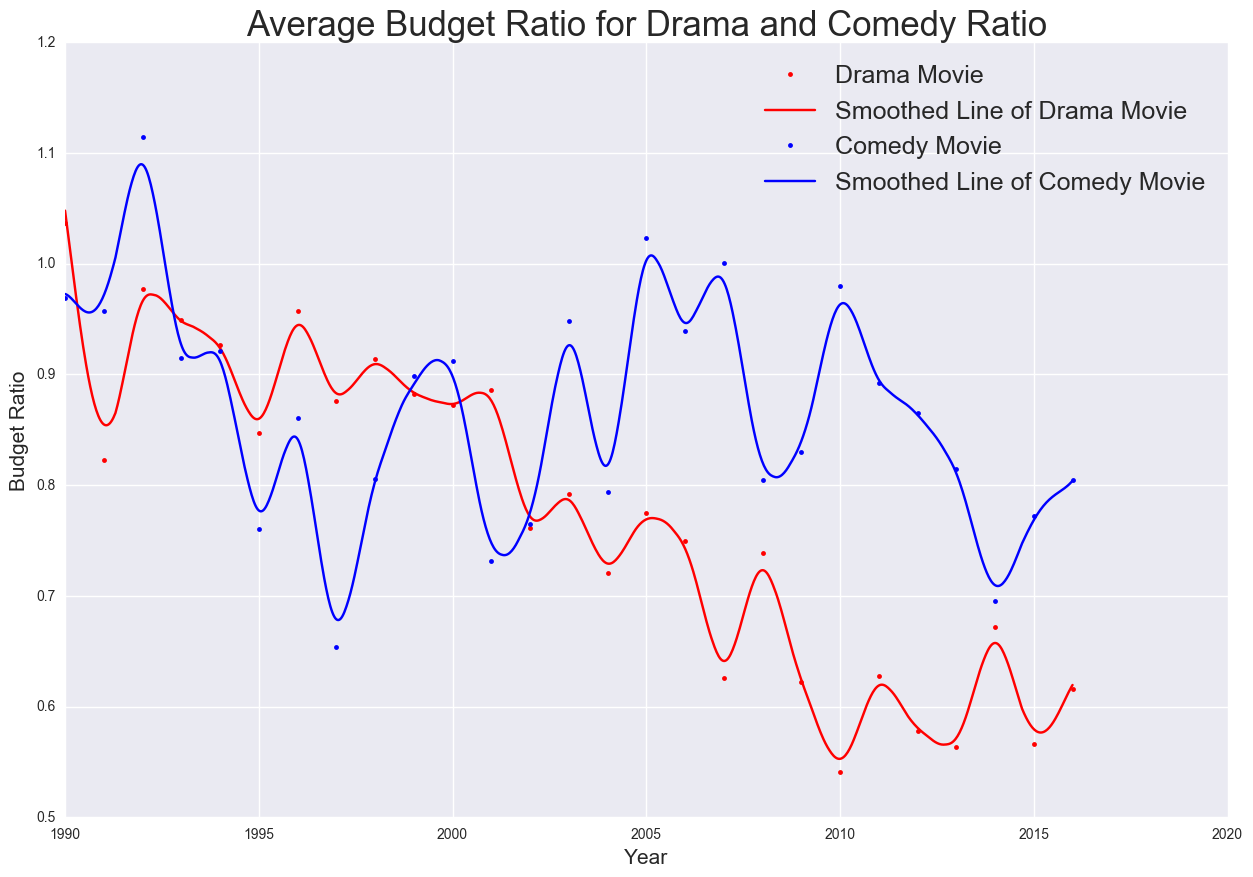

In [18]:
x = np.array(Rate['Year'])
y1 = np.array(Rate['Com_Bugt'])
y2 = np.array(Rate['Dra_Bugt'])


xx = np.linspace(x.min(),x.max(), 1000)

# interpolate + smooth
itp1 = interp1d(x,y1, kind='linear')
itp2 = interp1d(x,y2, kind='linear')

window_size, poly_order = 101, 4
yy1_sg = savgol_filter(itp1(xx), window_size, poly_order)
yy2_sg = savgol_filter(itp2(xx), window_size, poly_order)



fig, ax = plt.subplots(figsize=(15, 10))

ax.plot(x, y2, 'r.', label= 'Drama Movie',color = 'red')
ax.plot(xx, yy2_sg, 'k', label= "Smoothed Line of Drama Movie",color = 'red')

ax.plot(x, y1, 'r.', label= 'Comedy Movie',color = 'Blue')
ax.plot(xx, yy1_sg, 'k', label= "Smoothed Line of Comedy Movie",color = 'Blue')


plt.xlabel('Year',fontsize = 15)
plt.ylabel('Budget Ratio',fontsize = 15)
plt.title('Average Budget Ratio for Drama and Comedy Ratio',fontsize = 25)
plt.legend(loc='best',prop={'size':18})
plt.show()

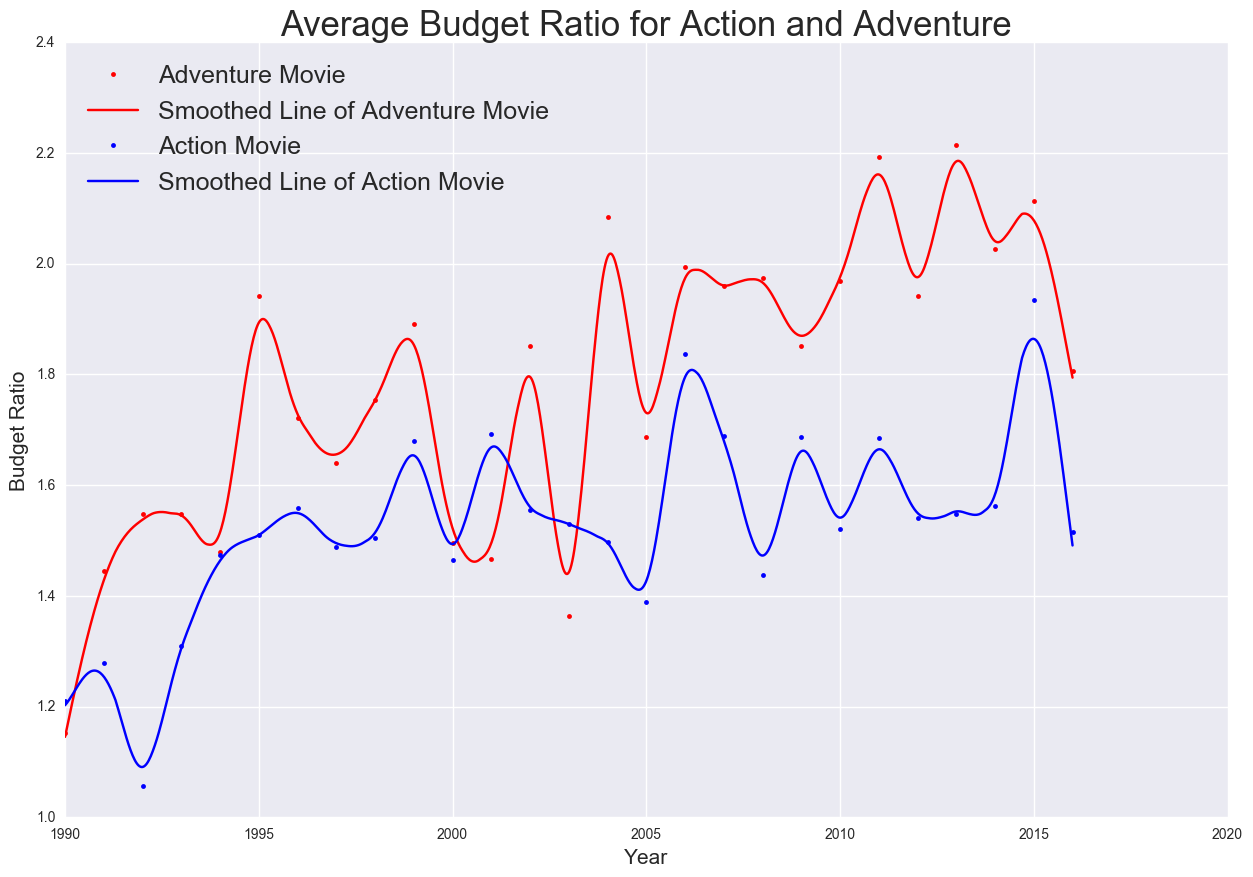

In [19]:
x = np.array(Rate['Year'])
y1 = np.array(Rate['Act_Bugt'])
y2 = np.array(Rate['Adv_Bugt'])


xx = np.linspace(x.min(),x.max(), 1000)

# interpolate + smooth
itp1 = interp1d(x,y1, kind='linear')
itp2 = interp1d(x,y2, kind='linear')

window_size, poly_order = 101, 4
yy1_sg = savgol_filter(itp1(xx), window_size, poly_order)
yy2_sg = savgol_filter(itp2(xx), window_size, poly_order)



fig, ax = plt.subplots(figsize=(15, 10))

ax.plot(x, y2, 'r.', label= 'Adventure Movie',color = 'red')
ax.plot(xx, yy2_sg, 'k', label= "Smoothed Line of Adventure Movie",color = 'red')

ax.plot(x, y1, 'r.', label= 'Action Movie',color = 'Blue')
ax.plot(xx, yy1_sg, 'k', label= "Smoothed Line of Action Movie",color = 'Blue')


plt.xlabel('Year',fontsize = 15)
plt.ylabel('Budget Ratio', fontsize = 15)
plt.title('Average Budget Ratio for Action and Adventure',fontsize = 25)
plt.legend(loc='best',prop={'size':18})
plt.show()

<style>
p.big {
    line-height: 50px;
}
</style>
<div style="text-align:justify">
<font size="4" face="Lucida bright">
From the above diagnostic test, we cannot simply explain the increasing popularity of action and adventure movies due to their increasing budget. We have cinsidered to add more factors to our model to increase the reliability. But the problem is that other factors cannot be easily transferred to numerical variables. So instead of continuing to add more factors to our linear model or use other statistic model, we want to start to think this problem from another perspective.
</font>

</div>

<style>
p.big {
    line-height: 30px;
}
</style>
<div style="text-align:justify">
<font size="5" face="Lucida bright">
What makes action movies and adventure movie different and why they can attract the audience in today but not in 1990?
<br>
</div>
<br>
<div style="text-align:justify">
<font size="4" face="Lucida bright">
We get some hints to this answer while we analysis a special subgroup of action and adventure movies – comic books movie. In recent years, increasing amount of successful comic books movies come into view. We might consider comic books movie contain the important information of the reason to our question. <br><br>


But first, we still need check whether is it true that on average the comic movies are popular these days.
</div>

In [ ]:
import plotly.plotly as py
import plotly.graph_objs as go

fig = {
  "data": [
    {
      "values": [0.0756,0.0338,1-0.0756-0.0338],
      "labels": [
        "Comic Books Movie",
        "In Average",
        "Others"
      ],
      "domain": {"x": [0, .48]},
      "name": "Action Movies",
      "hoverinfo":"label+percent+name",
      "hole": .4,
      "type": "pie"
    },     
    {
      "values": [0.0724, 0.0394,1-0.0724-0.0394],
      "labels": [
        "Comic Books Movie",
        "In Average",
        "Others"
      ],
      "textposition":"inside",
      "domain": {"x": [.52, 1]},
      "name": "Adventure Movies",
      "hoverinfo":"label+percent+name",
      "hole": .4,
      "type": "pie"
    }],
  "layout": {
        "title":"How much does Comic Books Movie contribute in average?",
        "annotations": [
            {
                "font": {
                    "size": 20
                },
                "showarrow": False,
                "text": "Action",
                "x": 0.20,
                "y": 0.5
            },
            {
                "font": {
                    "size": 20
                },
                "showarrow": False,
                "text": "Adventure",
                "x": 0.83,
                "y": 0.5
            }
        ]
    }
}
py.iplot(fig)


<style>
p.big {
    line-height: 30px;
}
</style>

<font size="4" face="Lucida bright">
<div style="text-align:justify">
From this pie plot, we know that on average, for action movies, one comic movie (belonging to action genre) contributes 7.56% to the total gross of action movies in one year, where one common action movie only contributes 3.38% to the total gross of action movies. The situation is similar for adventure movies. We conclude that comic books movies do follow the growing trend of action movies and adventure movies. 
<br>
So, what’s makes the comic books movie different from other types of movies? Through the data mining, we give an explaining based on the following plots.
</div>

<style>
p.big {
    line-height: 30px;
}
</style>

<font size="4" face="Lucida bright">
<div style="text-align:justify">
This plot indicates the IMDB score among different age groups (19-25, 25-40, 41). We notice that, for comic books movie, the difference of rating among four age groups is smaller than it for non-comic books movie and it for comedy and adventure movies. We can interpret it as that comic books movies usually achieve the similar popularities in different age group.
</div>

<div style="text-align:justify">
Such finding drives us to check the variance of the IMDB score in different age groups for different types of movies. 
We consider that if such variance is small, that type of movie is welcomed in all age groups and vice versa. Hence, we plot the such variance in each year to analysis the action movies and comedy movies.
</div>

In [ ]:
x = np.array(Rate['Year'])
y1 = np.array(Rate['var1'])
y2 = np.array(Rate['var2'])

xx = np.linspace(x.min(),x.max(), 1000)

# interpolate + smooth
itp1 = interp1d(x,y1, kind='linear')
itp2 = interp1d(x,y2, kind='linear')
window_size, poly_order = 101, 4
yy1_sg = savgol_filter(itp1(xx), window_size, poly_order)
yy2_sg = savgol_filter(itp2(xx), window_size, poly_order)


fig, ax = plt.subplots(figsize=(15, 10))

ax.plot(x, y2, 'r.',color = 'red')
ax.plot(xx, yy2_sg, 'k',color = 'red',label = 'Comedy')

ax.plot(x, y1, 'r.', color = 'Blue')
ax.plot(xx, yy1_sg, 'k',color = 'Blue',label = 'Action')

plt.xlabel('Year',fontsize = 15)
plt.ylabel('Variance',fontsize = 15)
plt.title(' Variance of IMDB Score for each Age Group',fontsize = 25)
plt.legend(loc='best',prop={'size':15})
plt.show()

<style>
p.big {
    line-height: 30px;
}
</style>

<font size="4" face="Lucida bright">
<div style="text-align:justify">
From the plot, we notice that the variance for comedy movies become higher than it for action movies from 1995. Moreover, the variance also achieves its peak in 2014, just like action movies did in 1991. It corresponds to the increasing popularity of action movies and decreasing popularity of comedy movies.
</div>

<style>
p.big {
    line-height: 30px;
}
</style>
 
<font size="4" face="Lucida bright">
<div style="text-align:justify">


Conclusions:
<br>
1.	People nowadays prefer more on action and adventure movies, less on comedy and drama movies, which is the opposite of people’s preference in 1990.<br>
<br>

2.	Even though it’s true that action movies and adventure movies usually have higher budget, based on the linear model, we cannot simply use the increasing budget to explain the increasing popularity of these two genres.<br><br>
3.	Notice that action movies and adventure movies (especially for comic books movie) have smaller variance in IMDB score among different age groups than comedy and drama movies have. This indicates that one of the reason about the increasing popularity of action and adventure movies is that they are not only popular among young children (18), but also attracts people in elder age.<br><br>
4.	Our explaining for the change of people’s preference for movie genres:<br>
The change of the primary consumers of movie results in the change of the overall preferences of the movies genres. (Action, Adventure rise, Drama, Comedy fall). <br>
Ex: Young children in about 1990 were largely influenced by the culture of comic books movie and high technology. Hence in today, when they become the majority consumers of movies, their expectation for movies is, unlike the expectation in 1990, become action and adventure movies, which largely contain the elements of comic books and high technology.
</div>

In [39]:
firsttwo = list()
for i in list(genredf.columns.values):
    a = genredf[i].copy()
    a.sort_values(inplace=True,ascending=False)
    sublist = list(a[0:2].index.values)
    #print sublist
    firsttwo = firsttwo + sublist
firsttwo1 = firsttwo
firsttwo = set(firsttwo)
firsttwo

{u'Action', u'Adventure', u'Comedy', u'Drama'}

In [37]:
maxdict = dict.fromkeys(list(genredf.columns))
for i in list(genredf.columns):
    maxdict[i] = list(genredf[i].loc[genredf[i] == max(genredf[i])].index)


maxgenrecount = {'Drama':0,'Comedy':0,'Adventure':0,'Action':0}
for j in list(genredf.columns):
    if 'Drama' in maxdict[j]:
        maxgenrecount['Drama'] += 1 
#for i in maxgenrecount.keys():
    if 'Comedy' in maxdict[j]:
        maxgenrecount['Comedy'] += 1 
    if 'Adventure' in maxdict[j]:
        maxgenrecount['Adventure'] += 1 
    if 'Action' in maxdict[j]:
        maxgenrecount['Action'] += 1 
print maxgenrecount

{'Drama': 25, 'Action': 0, 'Comedy': 2, 'Adventure': 0}


In [42]:
act_series = []
for i in Act_Series_movie['Title']:
    act_series.append(i)
under_18 = []
y18_y29 = []
y30_y44 = []
over45 = []

for i in act_series:
    under_18.append(Movie_info_search(i)['<18 rating'])
    y18_y29.append(Movie_info_search(i)['18-29 rating'])
    y30_y44.append(Movie_info_search(i)['30-44 rating'])
    over45.append(Movie_info_search(i)['45+ rating'])

non_comic = []

for i in Action_Film['Title']:
    if i not in act_series:
        non_comic.append(i)
under_18_2 = []
y18_y29_2 = []
y30_y44_2 = []
over45_2 = []

for i in non_comic:
    under_18_2.append(Movie_info_search(i)['<18 rating'])
    y18_y29_2.append(Movie_info_search(i)['18-29 rating'])
    y30_y44_2.append(Movie_info_search(i)['30-44 rating'])
    over45_2.append(Movie_info_search(i)['45+ rating'])

In [ ]:
N = 2
ind = np.arange(N)  # the x locations for the groups
width = 0.1       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

yvals = [sum(under_18)/len(under_18), sum(under_18_2)/len(under_18_2)]
rects1 = ax.bar(ind, yvals, width, color='r')

zvals = [sum(y18_y29)/len(y18_y29), sum(y18_y29_2)/len(y18_y29_2)]
rects2 = ax.bar(ind+width, zvals, width, color='g')

kvals = [sum(y30_y44)/len(y30_y44), sum(y30_y44_2)/len(y30_y44_2)]
rects3 = ax.bar(ind+width*2, kvals, width, color='b')

qvals = [sum(over45)/len(over45), sum(over45_2)/len(over45_2)]
rects4 = ax.bar(ind+width*3, qvals, width, color='y')

ax.set_ylabel('Scores')
ax.set_xticks(ind+width)
ax.set_xticklabels(('Comic', 'Non-comic'))
ax.legend((rects1[0], rects2[0], rects3[0],rects4[0]), ('under 18 rating', '18-29 rating', '30-44 rating','over 45 rating') )
ax.set_ylim([6,7.5])
ax.title.set_text('Imdb Rating for comic movies and Non-comic movies in different age groups')

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

plt.show()